# Creating synthetic data to mimic the VitaRenal dataset

Power calculation (based on repeated measures ANOVA, N=24, 4 time levels, and 2 equal sized groups, with 80% power and 5% alpha) shows that effects at the higher boundary of small effect sizes and the lower boundary of medium sized effects of Cohen’s d=.50-.55 (ƞ2=.07) can be reliably detected. This calculation allows for the planned linear mixed-model within-between interaction analyses, described at par. 8.3. For the analyses of main effects on the main endpoint/primary outcome (decrease over time on both cognitive biases within whole sample) the power with a N=24 sample size is considerably larger. Previous studies from our team among healthy volunteers with fatigue complaints showed similar effect sizes after less intensive single-session CBM (Pieterse & Bode, 2018). As LMM analyses can account for missing values effectively, partial missingness of datapoints is allowed and does not necessarily affect this power calculation.

- N = 24,
- Repeated measures = 4
- Groups = 2

In [48]:
2 * 4 * 24

192

In [57]:
from pymer4 import Lmer, simulate_lmm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from local_MERF import MERF
from jmspack.ml_utils import optimize_model
from jmspack.utils import silence_stdout
from sklearn.ensemble import RandomForestRegressor

In [4]:
if "jms_style_sheet" in plt.style.available:
    plt.style.use("jms_style_sheet")

In [68]:
number_observations = 4 # amount of observations per group (i.e. user_id)
number_predictors = 5
number_groups = 30 # amount of groups (i.e. user_id)

df, blups, coefficient = simulate_lmm(num_obs=number_observations,
    num_coef=number_predictors,
    num_grps=number_groups,
    coef_vals=None,
    corrs=None,
    grp_sigmas=0.25,
    mus=0.0,
    sigmas=1.0,
    noise_params=(0, 2),
    family='gaussian',
    seed=69420)

df = (df.assign(m00_name= lambda x: np.tile(["m00", "m03", "m06", "m09"], number_groups))
      .assign(diagnosis = np.repeat([0, 1], int(df.shape[0]/2)))
      .rename(columns={"Group": "user_id"}, inplace=False)
      .assign(user_id=lambda x: x["user_id"].astype(int))
      )

In [69]:
coefficient

array([0.53109224, 0.35676397, 0.51311614, 0.32530468, 0.45724967,
       0.01407327])

In [70]:
display(df.head()), df.shape

,DV,IV1,IV2,IV3,IV4,IV5,user_id,m00_name,diagnosis
0,1.310004,1.282629,0.041641,0.026445,1.112682,-1.396378,1,m00,0
1,0.348110,-0.384780,0.663529,-1.125871,0.127171,0.029313,1,m03,0
2,-0.901572,-0.012763,0.031757,0.363677,-1.443745,-1.150963,1,m06,0
3,1.684844,-0.719206,0.488108,1.113077,-0.524331,0.438103,1,m09,0
4,0.840559,0.621639,-1.237202,0.283866,1.043195,-0.263725,2,m00,0


(None, (120, 9))

In [71]:
predictor_list = df.filter(regex="IV").columns.tolist()

# df[predictor_list] = df[predictor_list].mask(np.random.random(df[predictor_list].shape) < .025)

In [72]:
target = "DV"
grp = "user_id"

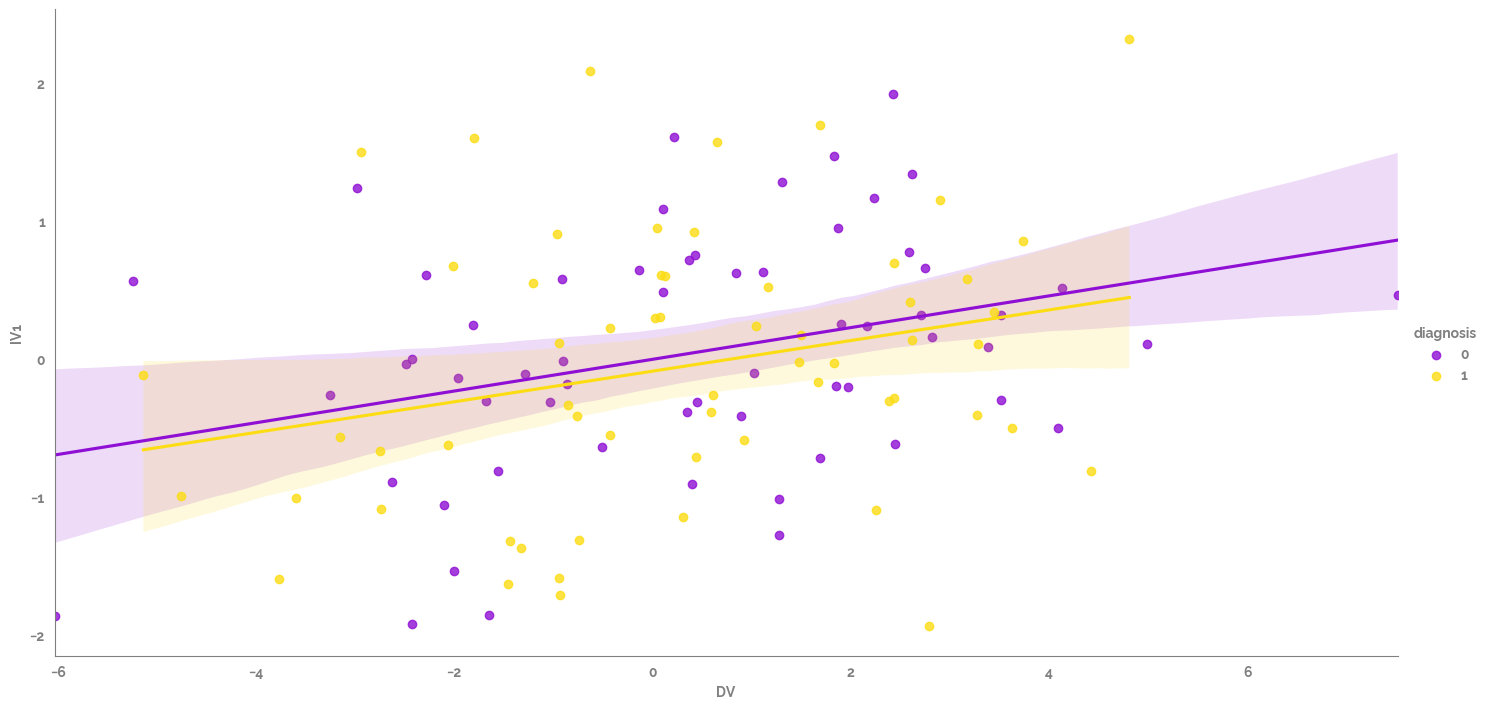

In [73]:
_ = sns.lmplot(data=df, x=target, y=predictor_list[0], hue="diagnosis", height=7, aspect=2)

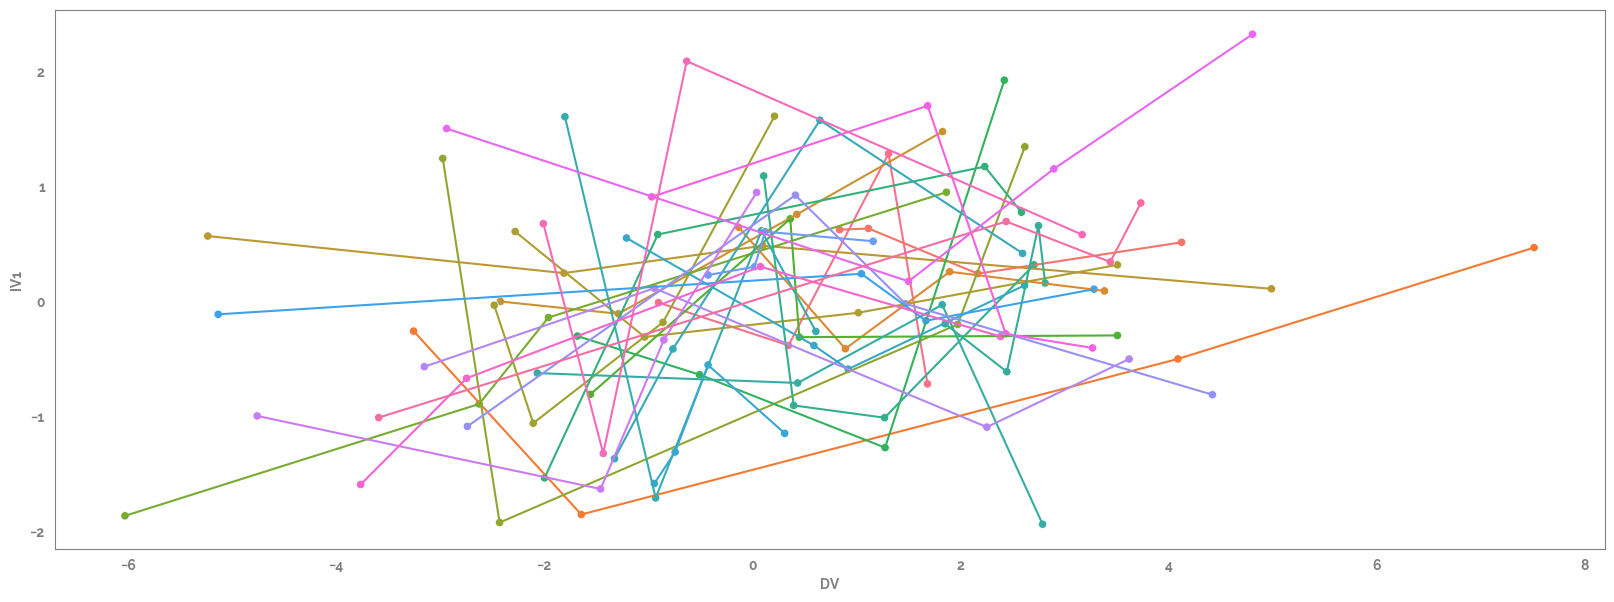

In [74]:
_ = plt.figure(figsize=(20, 7))
_ = sns.lineplot(data=df.assign(user_id=lambda x: x[grp].astype("category")), x=target, y=predictor_list[0], hue=grp, legend=False)
_ = sns.scatterplot(data=df.assign(user_id=lambda x: x[grp].astype("category")), x=target, y=predictor_list[0], hue=grp, legend=False)

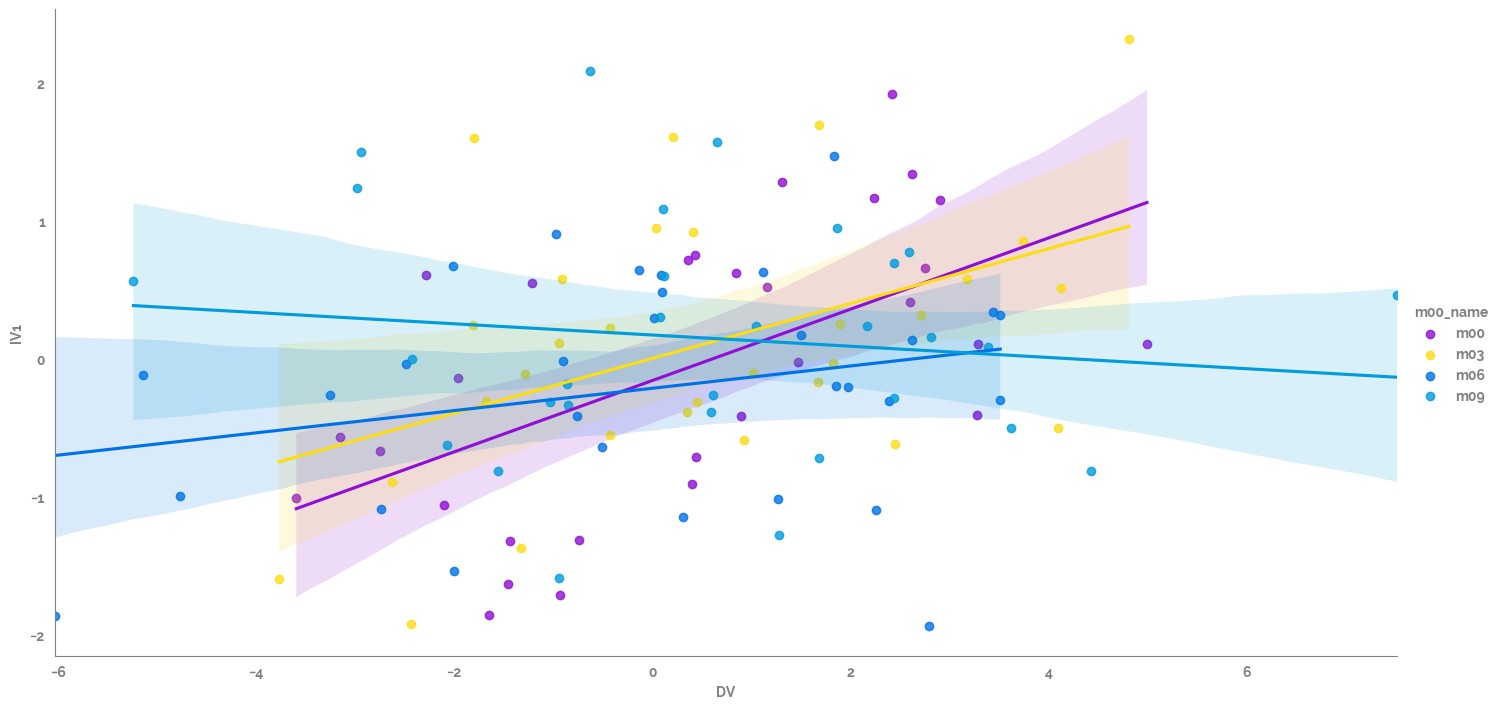

In [77]:
_ = sns.lmplot(data=df, x=target, y=predictor_list[0], hue="m00_name", height=7, aspect=2)

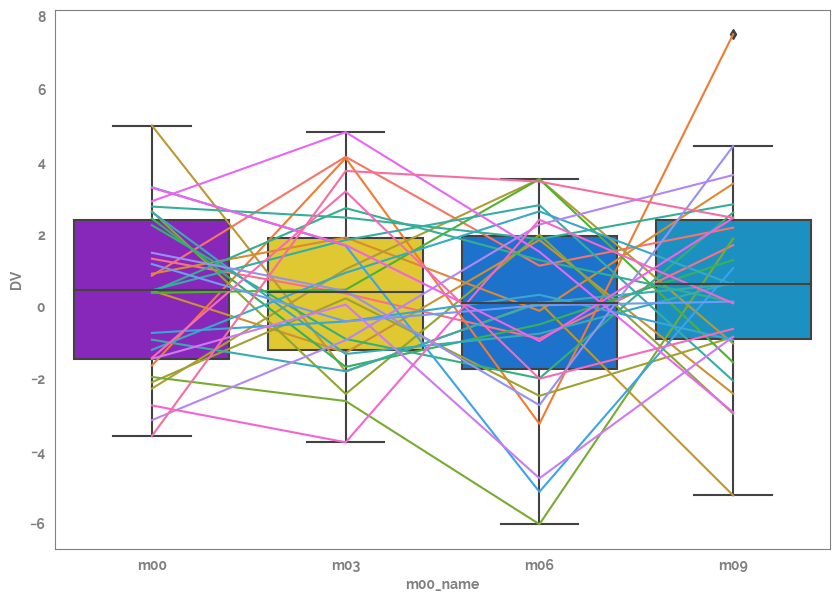

In [78]:
_ = plt.figure(figsize=(10, 7))
_ = sns.boxplot(data=df, x="m00_name", y=target)
_ = sns.lineplot(data=df.assign(user_id=lambda x: x[grp].astype("category")), x="m00_name", y=target, hue=grp, legend=False)

## Specify the predictor list and make 2.5% of the predictor columns np.nans

In [79]:
X = df[predictor_list + [grp]]
y = df[target]

In [80]:
X_train = X.sample(frac=0.8, random_state=42)
X_test = X.drop(X_train.index, axis=0)
y_train = y.loc[X_train.index]
y_test = y.drop(X_train.index, axis=0)

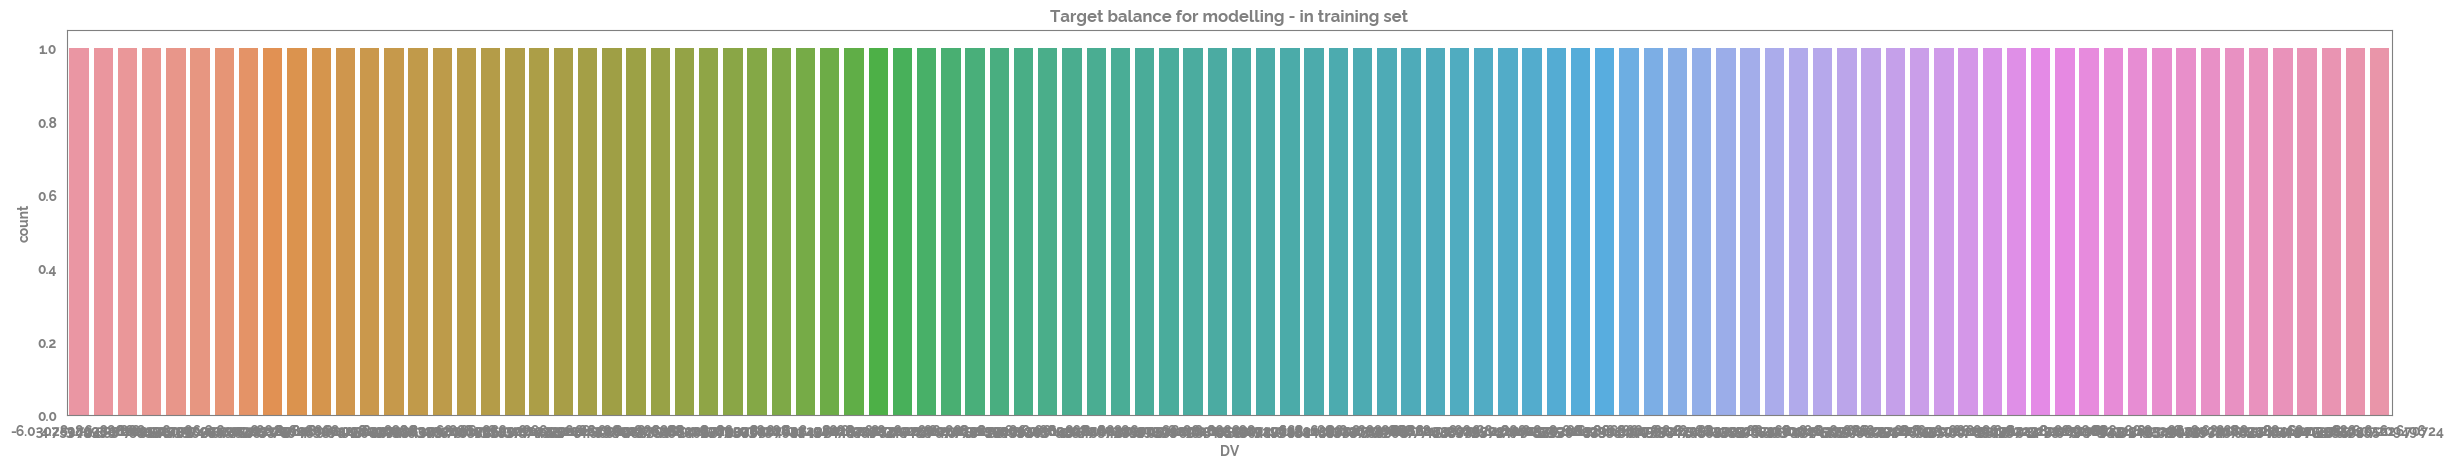

In [81]:
_ = plt.figure(figsize=(30,5))
_ = sns.countplot(x=y_train)
_ = plt.title("Target balance for modelling - in training set")
_ = plt.show()

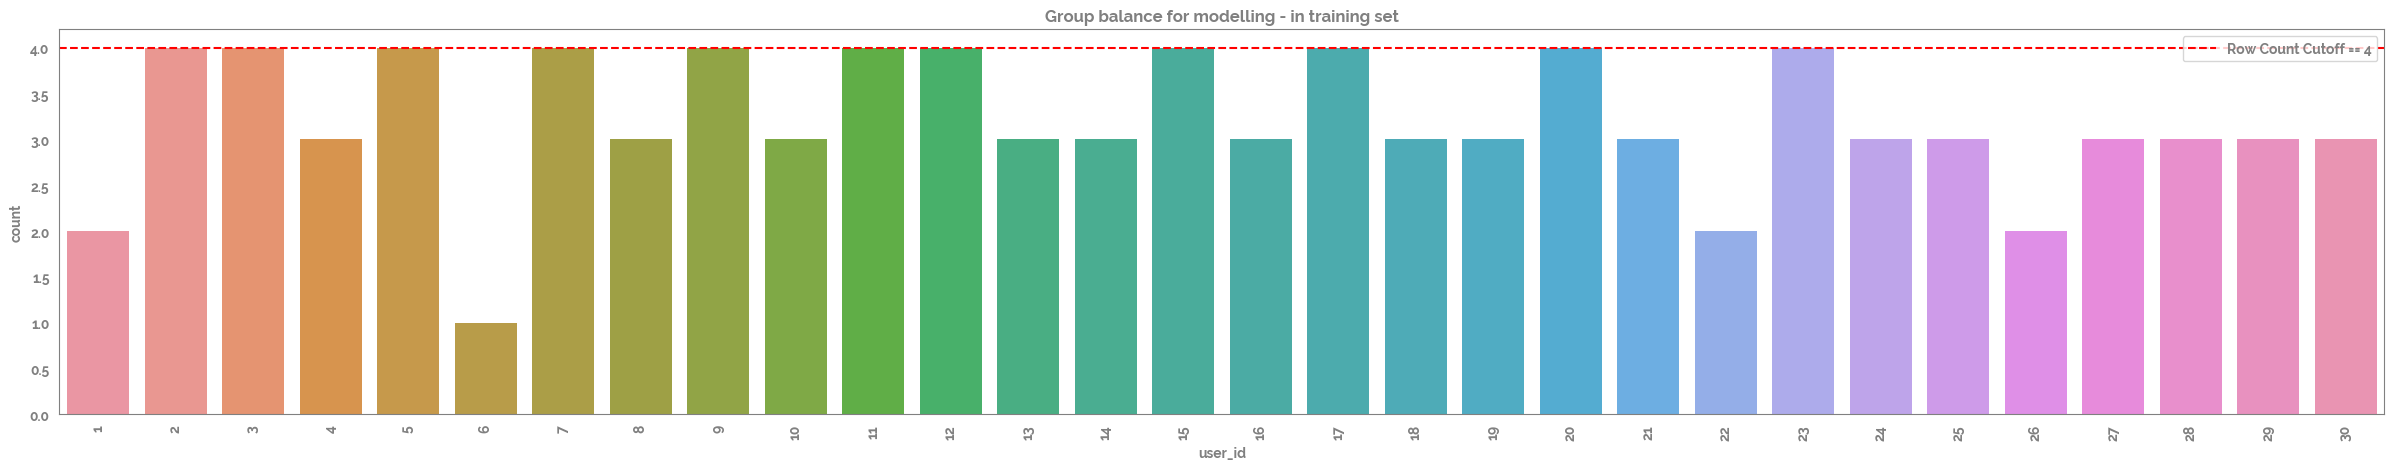

In [82]:
_ = plt.figure(figsize=(30,5))
_ = sns.countplot(x=X_train[grp])
_ = plt.title("Group balance for modelling - in training set")
cutoff = 4
_ = plt.axhline(cutoff, c="red",ls="--", label=f"Row Count Cutoff == {cutoff}")
_ = plt.legend()
_ = plt.xticks(rotation=90)
_ = plt.show()

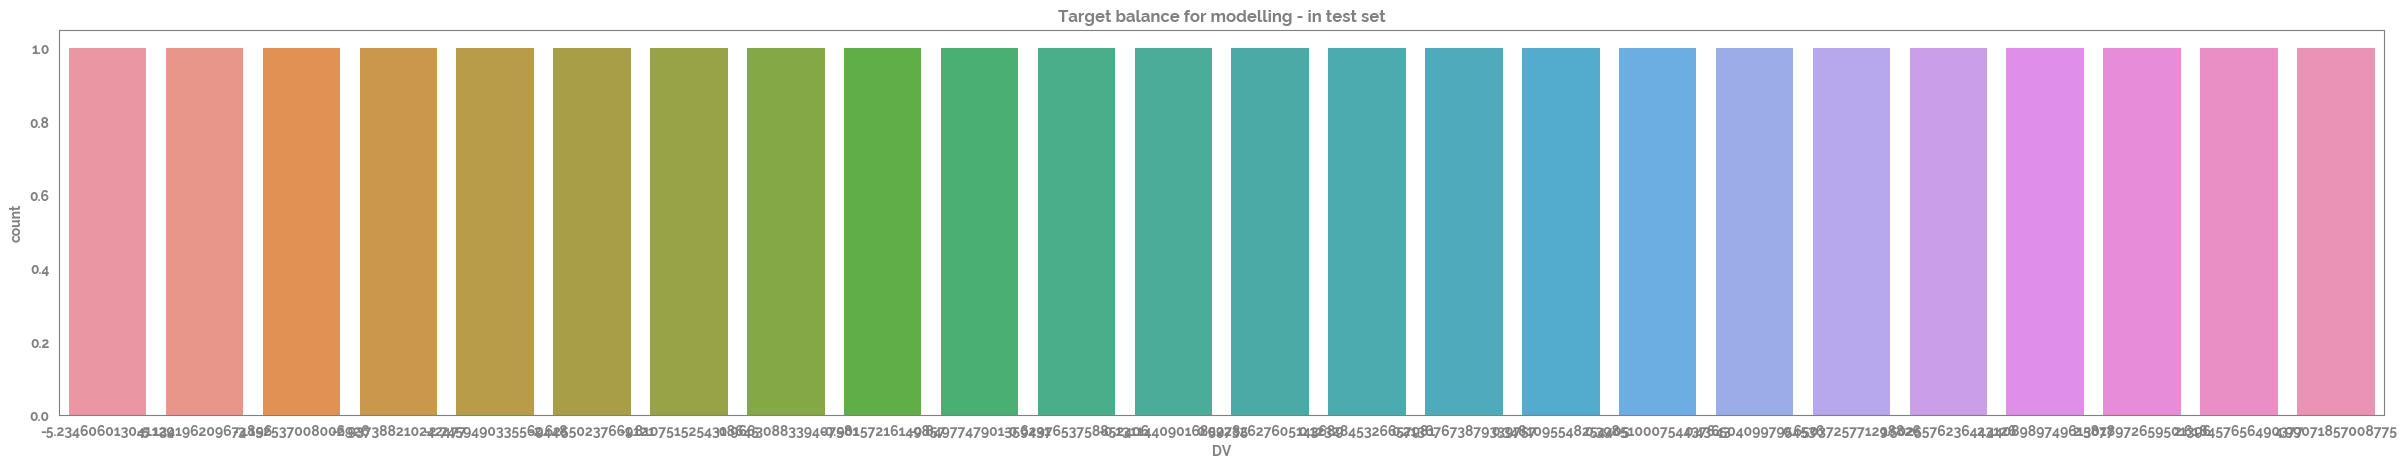

In [83]:
_ = plt.figure(figsize=(30,5))
_ = sns.countplot(x=y_test)
_ = plt.title("Target balance for modelling - in test set")
_ = plt.show()

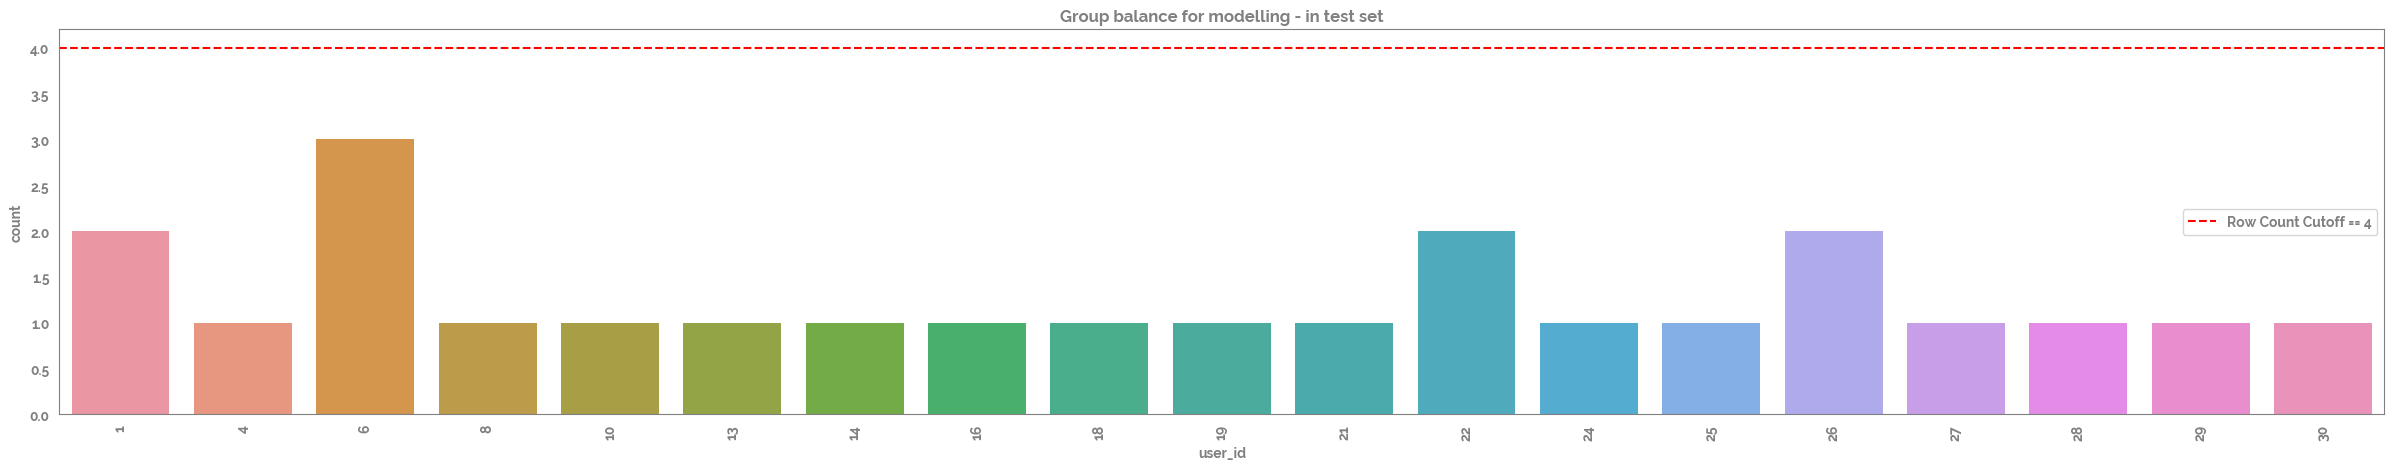

In [84]:
_ = plt.figure(figsize=(30,5))
_ = sns.countplot(x=X_test[grp])
_ = plt.title("Group balance for modelling - in test set")
cutoff = 4
_ = plt.axhline(cutoff, c="red", ls="--", label=f"Row Count Cutoff == {cutoff}")
_ = plt.legend()
_ = plt.xticks(rotation=90)
_ = plt.show()

In [85]:
tmp = X_train.apply(lambda x: x.nunique()).sort_values()
tmp

user_id    30
IV1        96
IV2        96
IV3        96
IV4        96
IV5        96
dtype: int64

In [86]:
import sklearn
from sklearn import metrics
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
def local_optimize_model(
    X: pd.DataFrame,
    y: pd.Series,
    estimator: BaseEstimator = sklearn.ensemble.RandomForestClassifier(),
    grid_params_dict: dict = {
        "max_depth": [1, 2, 3, 4, 5, 10],
        "n_estimators": [10, 20, 30, 40, 50],
        "max_features": ["log2", "auto", "sqrt"],
        "criterion": ["gini", "entropy"],
    },
    gridsearch_kwargs: dict = {"scoring": "roc_auc", "cv": 3, "n_jobs": -2},
    rfe_kwargs: dict = {"n_features_to_select": 2, "verbose": 1},
):

    # Perform a 75% training and 25% test data split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, 
        # stratify=y, 
        random_state=42
    )

    # Instantiate grid_dt
    grid_dt = GridSearchCV(
        estimator=estimator, param_grid=grid_params_dict, **gridsearch_kwargs
    )

    # Optimize hyperparameter
    _ = grid_dt.fit(X_train, y_train)

    # Extract the best estimator
    optimized_estimator = grid_dt.best_estimator_

    # Create the RFE with a optimized random forest
    rfe = RFE(estimator=optimized_estimator, **rfe_kwargs)

    # Fit the eliminator to the data
    _ = rfe.fit(X_train, y_train)

    # create dataframe with features ranking (high = dropped early on)
    feature_ranking = pd.DataFrame(
        data=dict(zip(X.columns, rfe.ranking_)), index=np.arange(0, len(X.columns))
    )
    feature_ranking = feature_ranking.loc[0, :].sort_values()

    # create dataframe with feature selected
    feature_selected = X.columns[rfe.support_].to_list()

    # create dataframe with importances per feature
    feature_importance = pd.Series(
        dict(zip(X.columns, optimized_estimator.feature_importances_.round(2)))
    )

    # Calculates the test set accuracy
    acc = metrics.accuracy_score(y_test, rfe.predict(X_test))

    print("\n- Sizes :")
    print(f"- X shape = {X.shape}")
    print(f"- y shape = {y.shape}")
    print(f"- X_train shape = {X_train.shape}")
    print(f"- X_test shape = {X_test.shape}")
    print(f"- y_train shape = {y_train.shape}")
    print(f"- y_test shape = {y_test.shape}")

    print("\n- Model info :")
    print(f"- Optimal Parameters = {optimized_estimator.get_params()}")
    print(f"- Selected feature list = {feature_selected}")
    print("- Accuracy score on test set = {0:.1%}".format(acc))

    return (
        optimized_estimator,
        feature_ranking,
        feature_selected,
        feature_importance,
        pd.DataFrame(optimized_estimator.get_params(), index=["optimal_parameters"]),
    )

In [87]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
def merf_prep(predictors_df:pd.DataFrame(), df_target_group:pd.DataFrame(), target:str, group:str):
    r"""Add missing values or negatives at random indices of a series
    Parameters
    ----------
    predictors_df: pandas.DataFrame()
        data frame including only the predictors
    df_target_group: pandas.DataFrame()
        data frame including only the outcome variable and the grouping variable
    target: str
        a string indicating the outcome variable (used to select from the df_target_group data frame)
    group: str
        a string indicating the grouping variable (used to select from the df_target_group data frame)
    Returns
    ----------
    X: pandas.DataFrame()
        A scaled version of the predictors data frame
    y: pandas.DataFrame()
        A data frame including the outcome variable
    Examples
    ----------
    >>> 
    
    """
        
    print(f"Outcome Variable: {target}")
    print(f"Predictors used: {', '.join(predictors_df.columns.tolist())}")
    # scale the data (mean center and std of 1)
    stdscaler = StandardScaler()
    scaled_predictors_df = pd.DataFrame(stdscaler.fit_transform(predictors_df), index=predictors_df.index, columns=predictors_df.columns)
    
    # define data frame - check index!!!!!!!!!
#     df_for_merf = scaled_predictors_df.merge(df_target_group[[target, group]], 
#                                         left_index=True, right_index=True).dropna(axis=0)
    df_for_merf = pd.concat([scaled_predictors_df, df_target_group[[target, group]]], axis=1) 
    
    # define predictors and target
    X = df_for_merf.drop(target, axis=1)
    y = df_for_merf[target]
    return X, y

def merf_train_fit(X:pd.DataFrame(), y:pd.DataFrame(), n_iterations:int, target:str, group:str, split=True, user_rf_params=None):
    r"""Add missing values or negatives at random indices of a series
    Parameters
    ----------
    X: pandas.DataFrame()
        data frame including only the predictors and the grouping variable
    y: pandas.DataFrame()
        data frame including only the outcome variable
    n_iterations: int
        an integer indicating the amount of iterations used to train the merf model
    target: str
        a string indicating the outcome variable (used to select from the df_target_group data frame)
    group: str
        a string indicating the grouping variable (used to select from the df_target_group data frame)
    Returns
    ----------
    output_dict: dictionary
        A dictionary comprising the trained merf model, the X and y training data frames used to train the model, 
        and the corresponding X and y test data frames
    Examples
    ----------
    >>> out_dic = merf_train_fit(X=X, y=y, n_iterations=n_it, target="Target", group="Grouping_variable")
    >>> model, X_train, X_test, y_train, y_test = out_dic["model"], out_dic["X_train"], out_dic["X_test"], 
        out_dic["y_train"], out_dic["y_test"]
    """
    if user_rf_params is None:
        rf_params = {'max_depth': 50, 'n_estimators': 300, 
                     'max_features': 'log2',
                     'criterion': 'mse', 'oob_score': True, 'n_jobs': -1}
    else:
        rf_params = user_rf_params
    
    # specify your merf and get your x, y, z and clusters training set
    merf = MERF(n_estimators=300, gll_early_stop_threshold=0.001, max_iterations=n_iterations, rf_params=rf_params)
    if split:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
        Z_train = np.ones((len(X_train), 1))
        clusters_train = X_train[group]
        X_train = X_train.drop(group, axis=1)
    else:
        X_train = X
        X_test = pd.Series(index=X_train.index)
        y_train = y
        y_test = pd.Series(index=X_train.index)
        Z_train = np.ones((len(X_train), 1))
        clusters_train = X_train[group]
        X_train = X_train.drop(group, axis=1)
    # fit your merf
    merf.fit(X_train, Z_train, clusters_train, y_train)
    output_dict = dict({"model": merf,
                    "X_train": X_train, 
                    "X_test": X_test, 
                    "y_train": y_train, 
                    "y_test": y_test,
                       "clusters_train":clusters_train})
    return output_dict

def merf_predict_plot(merf, X_train:pd.DataFrame(), X_test:pd.DataFrame(), 
                      y_train:pd.DataFrame(), y_test:pd.DataFrame(), target:str, group:str, savefig:bool):
    r"""Add missing values or negatives at random indices of a series
    Parameters
    ----------
    merf: a trained merf model
    X_train: pandas.DataFrame()
        data frame including only the predictors and grouping variable used to train the merf model
    X_test: pandas.DataFrame()
        data frame including only the predictors and grouping variable NOT used to train the merf model
    y_train: pandas.DataFrame()
        data frame including only the outcome variable used to train the merf model
    y_test: pandas.DataFrame()
        data frame including only the outcome variable NOT used to train the merf model
    target: str
        a string indicating the outcome variable (used to select from the df_target_group data frame)
    group: str
        a string indicating the grouping variable (used to select from the df_target_group data frame)
    Shows
    ----------
    diagnostic plots to evaluate the performance of the trained merf model on the test data
    
    Returns
    ----------
    r_sq: int
        The r-squared score derived from the predicted values of y (based on the trained merf model), in 
        comparison with the y test values.
    rmse: int
        The root mean squared error derived from the predicted values of y (based on the trained merf model), in 
        comparison with the y test values.
    
    Examples
    ----------
    >>> r_sq, rmse=merf_predict_plot(merf=out_dic["model"], X_train=out_dic["X_train"], X_test=out_dic["X_test"], 
                                    y_train=out_dic["y_train"], y_test=out_dic["y_test"], target="Time", group="Pig")
    """
    # create flatten function - super useful for flattening lists of lists into a single list
    flatten = lambda l: [item for sublist in l for item in sublist]
    
    # use your merf to predict your y based on your X, Z and clusters tests
    clusters_test = X_test[group]
    X_test = X_test.drop(group, axis=1)
    Z_test = np.ones((len(X_test), 1))
    y_pred = merf.predict(X_test, Z_test, clusters_test)
    # diagnostic plots
    plt.figure(figsize=[15/1.5,10/1.5])
    plt.subplot(221)
    plt.plot(merf.gll_history)
    plt.grid('on')
    plt.ylabel('GLL')
    plt.xlabel('Iteration')

    plt.subplot(222)
    D_hat_history = [x[0][0] for x in merf.D_hat_history]
    plt.plot(D_hat_history)
    plt.grid('on')
    plt.ylabel('sigma_b2_hat')
    plt.xlabel('Iteration')

    plt.subplot(223)
    plt.plot(merf.sigma2_hat_history)
    plt.grid('on')
    plt.ylabel('sigma_e2_hat')
    plt.xlabel('Iteration')

    plt.subplot(224)
    plt.hist(flatten(merf.trained_b.values), bins=15)
    plt.grid('on')
    plt.xlabel('b_i')
    plt.title('Distribution of b_is')

    # evaluate the model using a bunch of metrics from sklearn
    print(f"R-Squared = {r2_score(y_test, y_pred)}")
    print(f"Root Mean Squared Error = {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}")
    print("================= Diagnostic Plots =================")

    r_sq = r2_score(y_test, y_pred)
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
    
    # plot the y_test vs the y_pred to see how good it was
    _ = plt.figure(figsize=(7,5))
    _ = plt.scatter(y_test, y_pred, color="r")
    _ = plt.title(f"Normalised true {target} vs Normalised predicted {target}")
    if savefig:
        _ = plt.savefig(f"plot/{target}_scatter_plot.png", dpi=400)
    _ = plt.show()
    
    return r_sq, rmse, y_test, y_pred

In [94]:
all_suggested_optimizations = pd.DataFrame()
for user in df.sample(n=20, random_state=69420)["user_id"].unique().tolist():
    df_select=df.loc[df["user_id"]==user, :]
    if df_select.shape[0] < 2:
        print(f"User id {user} not run due to being too short")
    else:
        X = df_select[predictor_list]
        print(f"User id: {user}, shape: {X.shape}")
        y = df_select[target]

        # need a minimum of 20 otherwise the oob scores in MERF are not reliable
        #n_estimator_list     = [1, 2, 3, 4, 5, 10]

        with silence_stdout():
            (optimized_estimator,
            feature_ranking,
            feature_selected,
            feature_importance, optimal_params_df) = local_optimize_model(X = X, 
                                                                    y = y, 
                                                                    estimator = RandomForestRegressor(random_state=69420), 
                                                                    grid_params_dict = { "max_depth": [1, 2, 3, 4, 5, 10],
                                                                                        "n_estimators": [10, 20, 30, 40, 50],
                                                                                        "max_features": ["log2", "auto", "sqrt"],
                                                                                        "criterion": ["squared_error", "absolute_error", "poisson"]}, 
                                                                    gridsearch_kwargs = { "scoring": "neg_mean_squared_error","cv": 2,"n_jobs": -2 }, 
                                                                    rfe_kwargs = { "n_features_to_select": 2,"verbose": 1 })
        suggested_optimizations = optimal_params_df.assign({"user_id": user, 
                                                            })
        all_suggested_optimizations = pd.concat([all_suggested_optimizations, suggested_optimizations])

User id: 15, shape: (4, 5)


/opt/miniconda3/envs/pymer4_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/miniconda3/envs/pymer4_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/envs/pymer4_env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/miniconda3/envs/pymer4_env/lib/python3.8/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/miniconda3/envs/pymer4_env/lib/python3.8/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/miniconda3/envs/pymer4_env/lib/python3.8/site-packag

KeyError: 'squared_error'

/opt/miniconda3/envs/pymer4_env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/miniconda3/envs/pymer4_env/lib/python3.8/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/miniconda3/envs/pymer4_env/lib/python3.8/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/miniconda3/envs/pymer4_env/lib/python3.8/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/miniconda3/envs/pymer4_env/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/opt/miniconda3/envs/pymer4_env/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/opt/miniconda3/envs/pymer4_env/lib/python3.8/

In [93]:
[x for x in sorted(sklearn.metrics.SCORERS.keys()) if "mean" in x]

['neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_root_mean_squared_error']

## Take the mode of the suggested optimizations¶

In [56]:
mode_optim_df = all_suggested_optimizations.mode().iloc[0, :]

rf_params_dict = {"max_depth":mode_optim_df["Max_depth"].astype("int"), 
                  "n_estimators":mode_optim_df["Number_of_estimators"].astype("int"),
                  "max_features":mode_optim_df["Max_features"], 
                  "criterion":mode_optim_df["Suggested_criterion"],
                 "oob_score":True,
                  "random_state":42,
                 "n_jobs":-4}

rf_params_dict

NameError: name 'all_suggested_optimizations' is not defined

### Specify the new predictors data frame based on the suggested features from the RFEs

In [ ]:
# _ = df.reset_index(inplace=True)

In [27]:
hold_out_users = df.sample(n=20, random_state=69420)["user_id"].unique().tolist()

In [28]:
train_test_users = df[~df['user_id'].isin(hold_out_users)]["user_id"].unique().tolist()

In [38]:
n_it = 10 # specify the maximum amount of iterations you would like the MERF to use during expectation–maximization (EM)

pred_df = (df
           [df["user_id"].isin(train_test_users)]
           .loc[:, predictor_list]
           .reset_index(drop=True)
          )
target_group_df = (df
                   [df["user_id"].isin(train_test_users)]
                   .loc[:, [target, grp]]
                   .reset_index(drop=True)
                  ) # a data frame including the target outcome variable and grouping variable

In [39]:
hold_out_pred_df = (df
                    [df["user_id"].isin(hold_out_users)]
           .loc[:, predictor_list]
           
           .reset_index(drop=True)
          )

hold_out_target_group_df = (df
                   [df["user_id"].isin(hold_out_users)]
                   .loc[:, [target, grp]]
                   .reset_index(drop=True)
                  ) # a data frame including the target outcome variable and grouping variable

In [40]:
# n_it = 10 # specify the maximum amount of iterations you would like the MERF to use during expectation–maximization (EM)

# pred_df = df[mode_optim_df["Suggested_features"]]
# target_group_df = df[[target, grp]] # a data frame including the target outcome variable and grouping variable

In [41]:
X, y = merf_prep(predictors_df=pred_df, df_target_group=target_group_df, target=target, group=grp)

Outcome Variable: DV
Predictors used: IV1, IV2, IV3, IV4, IV5, IV6, IV7, IV8, IV9, IV10


In [42]:
X.shape

(28, 11)

In [43]:
y.shape

(28,)

In [46]:
sclr = MinMaxScaler()
y = pd.DataFrame(sclr.fit_transform(y.values.reshape(-1, 1)).reshape(1, -1), index=[y.name]).T[target]

In [47]:
out_dic = merf_train_fit(X=X, y=y, n_iterations=n_it, target=target, group=grp, split=False, user_rf_params=rf_params_dict)

NameError: name 'rf_params_dict' is not defined

In [ ]:
model, X_train, X_test, y_train, y_test, clusters_train = (out_dic["model"], out_dic["X_train"], 
                                                           out_dic["X_test"], out_dic["y_train"], 
                                                           out_dic["y_test"], out_dic["clusters_train"])

In [ ]:
# use your merf to predict your y based on your X, Z and clusters tests
Z_train = np.ones((len(X_train), 1))
y_pred = model.predict(X_train, Z_train, clusters_train)
print(f"R-Squared = {r2_score(y_train, y_pred)}")
print(f"Root Mean Squared Error = {round(np.sqrt(mean_squared_error(y_train, y_pred)), 2)}")

R-Squared = 0.44074892270393207
Root Mean Squared Error = 0.18


In [ ]:
X_test_v2 = (df
           [df["user_id"].isin(train_test_users)]
           .loc[df["session_id"] == 2, mode_optim_df["Suggested_features"] +["user_id"]]
           .reset_index(drop=True)
          )
y_test_v2 = (df
                   [df["user_id"].isin(train_test_users)]
                   .loc[df["session_id"] == 2, target]
#                    .reset_index(drop=True)
                  )

# X_test_v2=df.loc[df["session_id"] == 2, mode_optim_df["Suggested_features"]+["user_id"]].reset_index(drop=True)
# y_test_v2=df.loc[df["session_id"] == 2, target]#.reset_index()

# X_test_v2=df[mode_optim_df["Suggested_features"]+["user_id"]]
# y_test_v2=df[target]
y_test_v2 = pd.DataFrame(sclr.fit_transform(y_test_v2.values.reshape(-1, 1)).reshape(1, -1), index=[y_test_v2.name]).T[target]

R-Squared = 0.40341867496403105
Root Mean Squared Error = 0.19
================= Diagnostic Plots =================


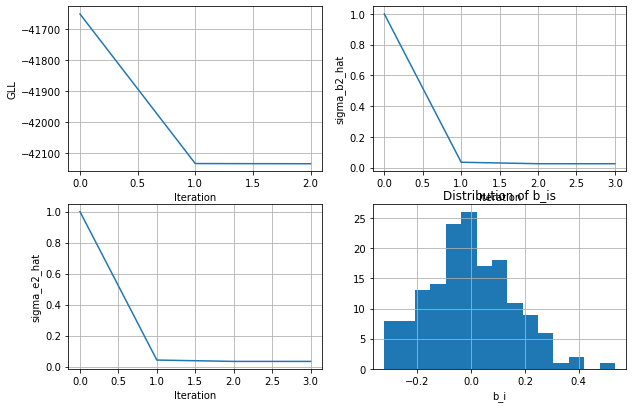

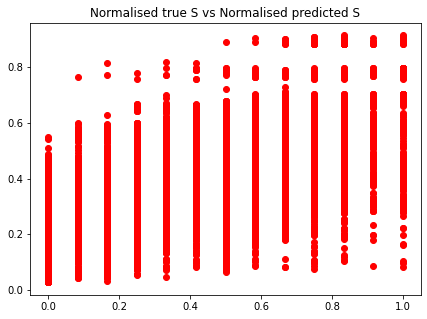

In [ ]:
# plot the model fit and prediction
r_sq, rmse, y_test, y_pred = merf_predict_plot(model, X_train=X_train, X_test=X_test_v2, y_train=y_train, 
                                               y_test=y_test_v2, target=target, group=grp, savefig=False)

In [ ]:
pred_test_df=pd.DataFrame({"y_pred":y_pred, target: y_test, 'user_id': X_test_v2['user_id']})
# pred_test_df = pred_test_df.groupby('user_id').mean()
merf_cors = pg.corr(pred_test_df["y_pred"], pred_test_df[target])
merf_cors

,n,r,CI95%,p-val,BF10,power
pearson,17382,0.639315,"[0.63, 0.65]",0.0,inf,1.0


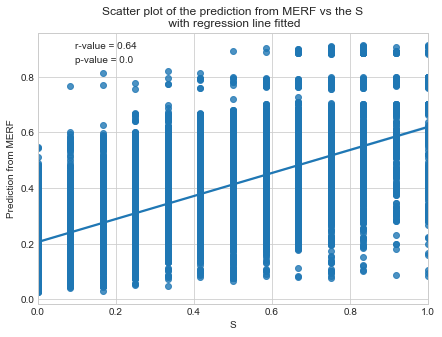

In [ ]:
from matplotlib.lines import Line2D
plt.style.use('seaborn-whitegrid')
legend_elements = [Line2D([0], [0], marker="", color="k", label=f"r-value = {np.round(merf_cors['r'].iat[0],2)}", linestyle="none", ),
                  Line2D([0], [0], marker="", color="k", label=f"p-value = {np.round(merf_cors['p-val'].iat[0],2)}", linestyle="none", )]
fig, ax = plt.subplots(figsize=(7,5))
sns.regplot(x=target, y="y_pred", data=pred_test_df).\
set_title(f"Scatter plot of the prediction from MERF vs the {target}\n with regression line fitted")
_ = ax.legend(handles=legend_elements)
plt.xlabel(target)
plt.ylabel(f"Prediction from MERF")
plt.show()

In [ ]:
user_id_min=pred_test_df.index.min()
user_id_max=pred_test_df.index.max()

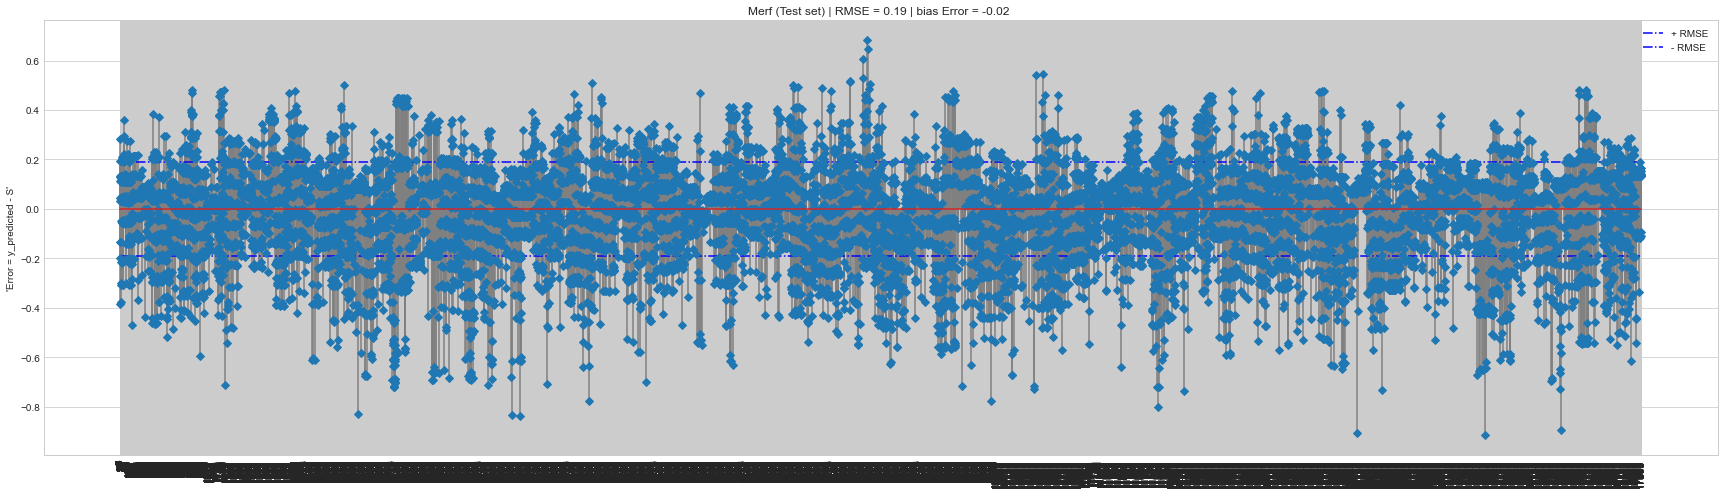

In [ ]:
df_test=pred_test_df
# plt.style.use('ggplot')
plt.figure(figsize=(30,8))
plt.title(f"Merf (Test set) | RMSE = {round(np.sqrt(mean_squared_error(df_test['y_pred'], df_test[target])),2)} | bias Error = { round(np.mean(df_test['y_pred'] - df_test[target]), 2)} ")
plt.stem(df_test.index, df_test['y_pred'] - df_test[target], use_line_collection=True, linefmt='grey', markerfmt='D')
plt.hlines(y=round(np.sqrt(mean_squared_error(df_test['y_pred'], df_test[target])),2), colors='b', linestyles='-.', label='+ RMSE', xmin = user_id_min, xmax = user_id_max) 
plt.hlines(y=round(-np.sqrt(mean_squared_error(df_test['y_pred'], df_test[target])),2), colors='b', linestyles='-.', label='- RMSE', xmin = user_id_min, xmax = user_id_max) 
plt.xticks(rotation=90, ticks=df_test.index)
plt.ylabel(f"'Error = y_predicted - {target}'")
# plt.ylim([-.5,.6])
plt.legend()
_ = plt.show()

In [ ]:
pred_test_df=pd.DataFrame({"y_pred":y_pred, target: y_test, 'user_id': X_test_v2['user_id']})
pred_test_df = pred_test_df.groupby('user_id').mean()
merf_cors = pg.corr(pred_test_df["y_pred"], pred_test_df[target])
merf_cors

,n,r,CI95%,p-val,BF10,power
pearson,158,0.886319,"[0.85, 0.92]",4.989286e-54,3.144e+50,1.0


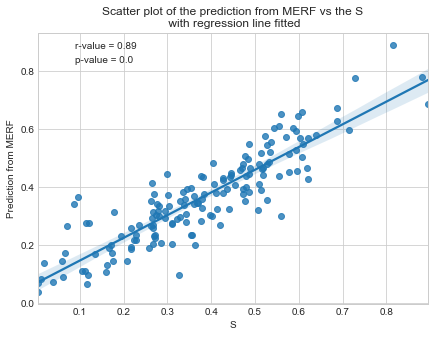

In [ ]:
from matplotlib.lines import Line2D
plt.style.use('seaborn-whitegrid')
legend_elements = [Line2D([0], [0], marker="", color="k", label=f"r-value = {np.round(merf_cors['r'].iat[0],2)}", linestyle="none", ),
                  Line2D([0], [0], marker="", color="k", label=f"p-value = {np.round(merf_cors['p-val'].iat[0],2)}", linestyle="none", )]
fig, ax = plt.subplots(figsize=(7,5))
sns.regplot(x=target, y="y_pred", data=pred_test_df).\
set_title(f"Scatter plot of the prediction from MERF vs the {target}\n with regression line fitted")
_ = ax.legend(handles=legend_elements)
plt.xlabel(target)
plt.ylabel(f"Prediction from MERF")
plt.show()

In [ ]:
user_id_min=pred_test_df.index.min()
user_id_max=pred_test_df.index.max()

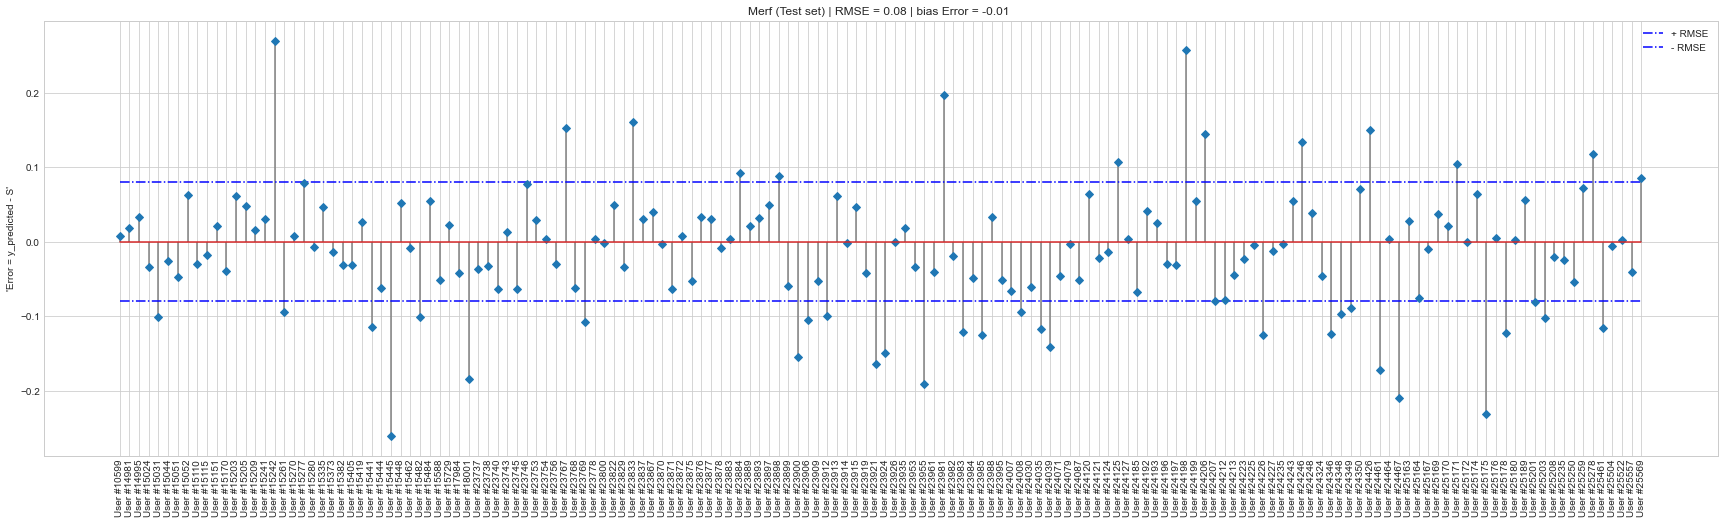

In [ ]:
df_test=pred_test_df
# plt.style.use('ggplot')
plt.figure(figsize=(30,8))
plt.title(f"Merf (Test set) | RMSE = {round(np.sqrt(mean_squared_error(df_test['y_pred'], df_test[target])),2)} | bias Error = { round(np.mean(df_test['y_pred'] - df_test[target]), 2)} ")
plt.stem(df_test.index, df_test['y_pred'] - df_test[target], use_line_collection=True, linefmt='grey', markerfmt='D')
plt.hlines(y=round(np.sqrt(mean_squared_error(df_test['y_pred'], df_test[target])),2), colors='b', linestyles='-.', label='+ RMSE', xmin = user_id_min, xmax = user_id_max) 
plt.hlines(y=round(-np.sqrt(mean_squared_error(df_test['y_pred'], df_test[target])),2), colors='b', linestyles='-.', label='- RMSE', xmin = user_id_min, xmax = user_id_max) 
plt.xticks(rotation=90, ticks=df_test.index)
plt.ylabel(f"'Error = y_predicted - {target}'")
# plt.ylim([-.5,.6])
plt.legend()
_ = plt.show()